In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.utils.fixes import loguniform

import scipy.stats as stats

from panel_utils import *

In [2]:
df = pd.read_csv("../_data/panelbigcap.csv", index_col="Date")
df = df.loc[df.index <= "2019.12.31"]
scale_interact_sort(df=df, micro_cols=micro_cols, macro_cols=macro_cols, interact=False)
df = df.round(4)

In [2]:
%store -r df

In [3]:
train = df.loc[df.index <= "2009.12.31"]
test = df.loc[df.index > "2009.12.31"]

train.shape, test.shape

((235787, 58), (162912, 58))

In [13]:
bestparams = []
predictions = []
naive_predictions = []
train_end_dates = []

naive_mean = DummyRegressor(strategy="mean")

for i in np.arange(2009,2019,1):
    train_realtime = df.loc[pd.to_datetime(df.index).year <= i]
    test_realtime = df.loc[(pd.to_datetime(df.index).year > i) & (pd.to_datetime(df.index).year < i+2)]
    
    X_train, y_train = train_realtime.drop(["EXCESS_RETURN_T+1"], axis=1), train_realtime["EXCESS_RETURN_T+1"]
    X_test, y_test = test_realtime.drop(["EXCESS_RETURN_T+1"], axis=1), test_realtime["EXCESS_RETURN_T+1"]

    est = Pipeline([
        ("pca", PCA()),
        ('regressor', LinearRegression())
        ])

    estimator = AdaBoostRegressor(base_estimator=est)
    
    param_grid = {
    "n_estimators": [2,3,4,5],
    "learning_rate": [0.05,0.1,0.25],
    'loss': ["square"],
    "base_estimator__pca__n_components": [1,2,4,6,8],
    'base_estimator__regressor__positive': [True],
    'base_estimator__regressor__fit_intercept': [True],
    }

    grid_search = GridSearchCV(
        estimator = estimator,
        param_grid = param_grid,
        scoring = "neg_mean_squared_error",
        refit = "neg_mean_squared_error",
        cv = holdout_cv(X_train, n_test = 4),
        n_jobs=-1,
        pre_dispatch=4
    )

    grid_search.fit(X_train, y_train)
    naive_mean.fit(X_train, y_train)

    predictions.extend(grid_search.predict(X_test).tolist())
    naive_predictions.extend(naive_mean.predict(X_test).tolist())
    bestparams.append(grid_search.best_params_)
    train_end_dates.append(pd.to_datetime(train_realtime.index[-1]).strftime('%Y-%m-%d'))
    
    print("train end",i)
    print("val MSE",grid_search.best_score_)

train end 2009
val MSE -0.01846028803966464
train end 2010
val MSE -0.01912861062463576
train end 2011
val MSE -0.019602461706332973
train end 2012
val MSE -0.014696299597458955
train end 2013
val MSE -0.009288410322973766
train end 2014
val MSE -0.00836697008876247
train end 2015
val MSE -0.008146931461235019
train end 2016
val MSE -0.008933470292546633
train end 2017
val MSE -0.008728460524284776
train end 2018
val MSE -0.00970110834492838


In [14]:
print("zeroOOSR2", modOOSR2(test["EXCESS_RETURN_T+1"].values, np.array(predictions)))
print("meanOOSR2: ", OOSR2(
    test["EXCESS_RETURN_T+1"].values, 
    np.array(predictions), 
    np.array(naive_predictions)
))

zeroOOSR2 0.02317849056126675
meanOOSR2:  0.0044163953823628255


[]

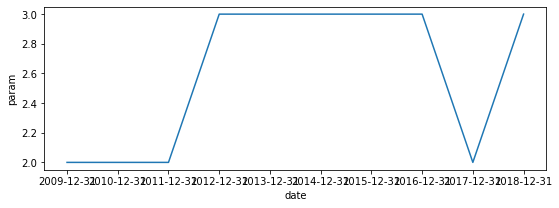

In [9]:
nlist = []

for paramdict in bestparams:
    nlist.append( paramdict['n_estimators'])
    
fig, ax = plt.subplots(figsize=(9,3))
ax.plot(train_end_dates, nlist)
ax.set_xlabel('date')
ax.set_ylabel('param')

plt.plot()

zeroOOSR2 0.02380334506584969
meanOOSR2:  0.00505325164937076